In [60]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import mat_neuron.core as matmodel

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [116]:
# model parameters: (α1, α2, β, ω, R, τm, τ1, τ2, τV, tref)
matparams = np.asarray([100, 2, -0.3, 7, 10, 10, 10, 200, 5, 2], dtype='d')
# these parameters should be slightly better but produce same output
# matparams = np.asarray([9.27063294,   1.77843253,  -0.29152392,   6.26916095,  13.37407994,
#                        10, 10, 200, 5, 2], dtype='d')
matstate = np.zeros(6, dtype='d')
model_dt = 0.5

# data parameters
duration = 20000
n_samples = int(duration / model_dt)
n_assim = 3
n_test = 0

# assimilation parameters
nthreads = 8
nwalkers = 2000
nsteps = 1000
matparams_i = [0,1,3]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

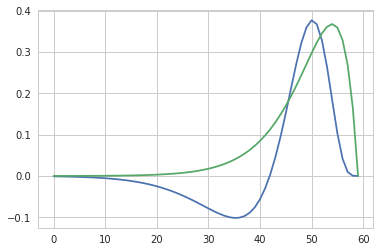

In [117]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0
upsample = int(stim_dt / model_dt)

# alpha filter
tau_h = 50
tt = np.arange(0, 600, stim_dt)
ka = np.flipud(tt / tau_h * np.exp(-tt / tau_h))

# difference of gammas:
from scipy.special import gamma
tau_h1 = 600. / 32
tau_h2 = 600. / 16
kg1 = 1/(gamma(6)*tau_h1)*(tt/tau_h1)**5 * np.exp(-tt/tau_h1)
kg2 = 1/(gamma(6)*tau_h2)*(tt/tau_h2)**5 * np.exp(-tt/tau_h2)
kg = np.flipud(kg1 - kg2 / 1.5)
kg /= np.linalg.norm(kg)

plt.plot(kg)
plt.plot(ka)

# select a filter
k1 = ka
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="same")

In [118]:
# generate data to fit
np.random.seed(1)
matmodel.random_seed(1)
data = []
stim = np.random.randn(int(n_samples / (stim_dt / model_dt)))
stim[:100] = 0
I = filter_stimulus(stim, k1)
#I = np.random.randn(n_samples)
for i in range(n_assim + n_test):
    states, spikes = matmodel.predict(matstate, matparams, I, model_dt, upsample=upsample, stochastic=True)
    z = np.nonzero(spikes)[0]
    d = {"I_stim": I,
         "duration": duration,
         "states": states,
         "spike_t": z, 
         "spike_v": spikes,
         #"lci": matmodel.log_intensity(matstate, matparams, I, z, model_dt)
         }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

182

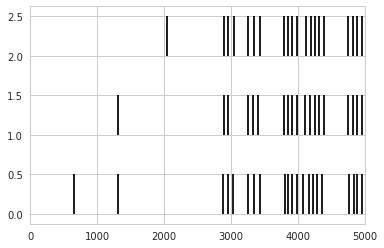

In [119]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5)
plt.xlim([0, 5000])
len(data[0]["spike_t"])

In [120]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  #priors.uniform(-5,   5),
                  priors.uniform( 0,  20),
                  #priors.uniform( 5,  20),
                ])
startparams = np.asarray([[-50, 200],
                          [-5, 10],
                          #[-5, 5],
                          [0, 20],
                          #[5, 20],
                         ], dtype='d')

# lasso prior on RF parameters
rf_lambda = 1.0
def rf_prior(theta):
    return -np.sum(np.abs(theta)) * rf_lambda

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()
rfparams = k1.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import lci_poisson
    mparams[matparams_i] = theta[:matparams_n]
    rfparams[:] = theta[matparams_n:]    
    ll = mat_prior(theta[:matparams_n]) + rf_prior(rfparams)
    if not np.isfinite(ll):
        return -np.inf
    # precalculate impulse matrix - this is affected by beta, so it has to be in here
    # this is a fairly expensive part of the calculation
    Aexp = matmodel.impulse_matrix(mparams, model_dt, reduced=True)
    lp = 0
    # this is very expensive
    I = filter_stimulus(stim, rfparams)
    for d in assim_data:
        lpq = lci_poisson(matstate, Aexp, mparams, I, d["spike_v"], model_dt, upsample)
        # NB: if you get overflow errors, adjust bounds to keep lci in a reasonable range (like -100 to 100)        
        # if (lci > 40).any():
        #    return -np.inf
        # lpq = np.sum(lci[d["spike_t"]]) - model_dt * np.sum(np.exp(lci))
        lp += lpq
    return ll + lp        

In [121]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams_f, k1])
print("lnpost of p_true: {}".format(lnpost_dyn(theta_true)))
# and this is our initial state
p0 = np.concatenate([startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1]),
                     startpos.normal_independent(nwalkers, k1, [0.1] * k1.size)],
                   axis=1)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(theta_true)
%time for theta_0 in p0: lnpost_dyn(theta_0)

lnpost of p_true: -1446.9494581837855
lnpost of p0 median: -2895.6901224289613
5.63 ms ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU times: user 18.1 s, sys: 27.1 s, total: 45.2 s
Wall time: 11.3 s


In [106]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------
    25       -3369     0:00:35     0:23:48
    50     -2400.9     0:01:12     0:23:30
    75       -2060     0:01:50     0:22:56
   100     -1849.9     0:02:28     0:22:31
   125     -1704.6     0:03:06     0:21:56
   150     -1606.5     0:03:43     0:21:17
   175     -1545.2     0:04:21     0:20:39
   200     -1510.5     0:04:58     0:20:03
   225     -1488.7     0:05:36     0:19:24
   250       -1475     0:06:13     0:18:47
   275     -1466.7     0:06:52     0:18:12
   300     -1460.8     0:07:31     0:17:37
   325     -1456.2     0:08:08     0:16:59
   350     -1452.4     0:08:45     0:16:20
   375     -1449.5     0:09:23     0:15:42
   400     -1447.5     0:10:01     0:15:05
   425     -1445.9     0:10:38     0:14:27
   450     -1444.8     0:11:16     0:13:49
   475     -1443.9     0:11:54     0:13:12
   500     -1443.2     0:12:31     0:12:34
   525     -1442.4     0:13:09     0:11:56
   550     

lnpost of p median: -1437.4909520762847
average acceptance fraction: 0.5493885000000001
[ 100.    2.    7.]
[ 101.76353614    1.9939085     7.02466619]


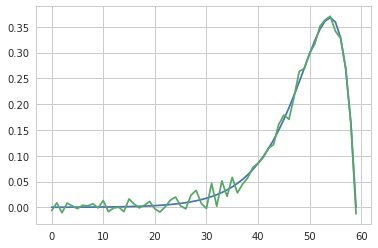

In [107]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
theta = np.median(pos, 0)
mparams[matparams_i] = theta[:matparams_n]
rfparams[:] = theta[matparams_n:]
plt.plot(k1)
plt.plot(rfparams)
print(matparams_f)
print(theta[:matparams_n])

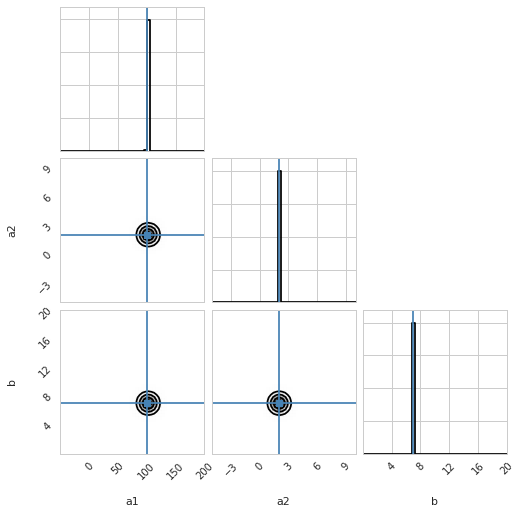

In [108]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['a1','a2','b','w', 'R']
c = corner(mpos,
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

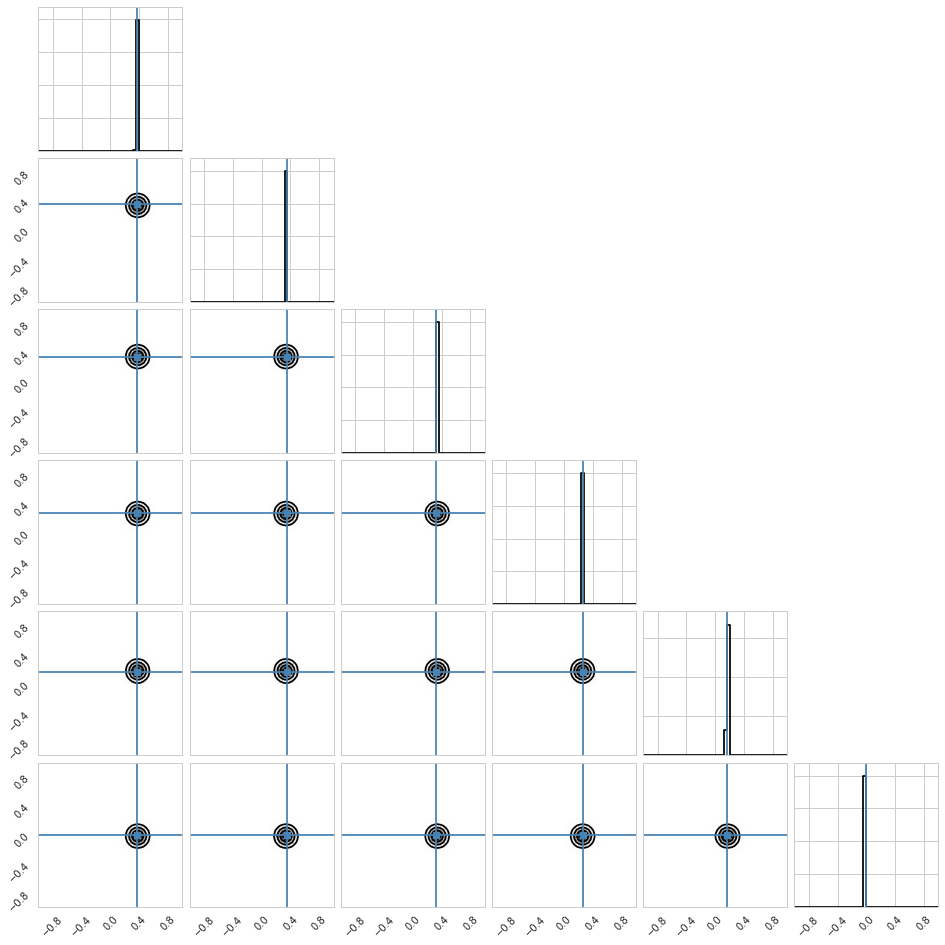

In [109]:
rpos = pos[:,matparams_n:]
c = corner(rpos[:,-6:],
           range=[[-1, 1] for i in range(6)],
           bins=50, smooth=2,smooth1d=0,
           truths=k1[-6:])

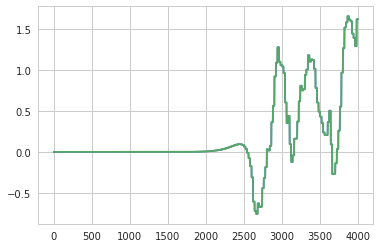

In [110]:
# see how well predictions line up
d = assim_data[0]

Y, S = matmodel.predict(matstate, mparams, I, model_dt, upsample=upsample, stochastic=True)
plt.plot(d["states"][:4000,1])
plt.plot(Y[:4000,1])

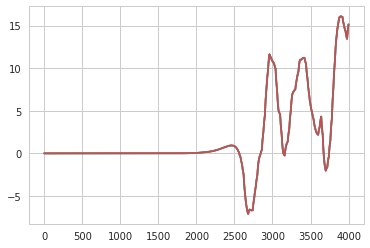

In [111]:
plt.plot(d["states"][:4000,0])
plt.plot(d["states"][:4000,0] - d["states"][:4000,4])
plt.plot(Y[:4000,0])

(0, 10000)

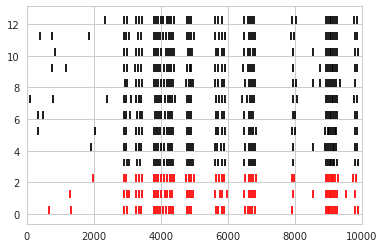

In [112]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5, 'r')

for i in range(len(data), len(data) + 10):
    Y, S = matmodel.predict(matstate, mparams, I, model_dt, upsample=upsample, stochastic=True)
    spk_t = S.nonzero()[0]
    plt.vlines(spk_t, i, i + 0.5)

plt.xlim(0, 10000)

In [ ]:
(d["lci"] - lci_guess).mean()